In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from contextlib import contextmanager
from pathlib import Path
import subprocess
from functools import partial


# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

np.random.seed(1234)

print("Device:", device)

Device: cuda


# We will study Schrödinger's non linear equation in 1D


### $$ih_t +\frac{1}{2}h_{xx} + \mid h\mid^2h = 0, \quad x \in [-5, 5], \quad t \in [0, \frac{\pi}{2}]$$

with the following boundary conditions:
$$h(0, x) = 2 sech(x)$$
$$h(t, -5) = h(t, 5)$$
$$h_x(t, -5) = h_x(t, 5)$$

This is different because we have Complex numbers and not real numbers. $\mid h\mid^2h$ is the module of h squared.
This will show how to solve complex-valued PDEs and periodic boundary conditions.

Let $u = Re(h)$ and $v = Im(h)$, then we can have a neural network prior with 2 outputs, one for $u$ and one for $v$. 



The network will learn to minimize a global mean squared loss composed of the following terms:
- The Initial condition loss (at $t=0$)
- The Boundary condition loss (at $x=-5,5$)
- The PDE loss (at all points in the domain and time)

The final loss will then be:
$$L = L_{IC} + L_{BC} + L_{f}$$

Where:
$$L_{IC} = \frac{1}{N_{IC}}\sum_{i=1}^{N_{IC}} |h(t=0, x_i) - 2sech(x_i)|^2$$
$$L_{BC} = \frac{1}{N_{BC}}\sum_{i=1}^{N_{BC}} |h(t, x_i) - h(t, x_{i+1})|^2 + |h_x(t, x_i) - h_x(t, x_{i+1})|^2$$
$$L_{f} = \frac{1}{N_{f}}\sum_{i=1}^{N_{f}} |ih_t +\frac{1}{2}h_{xx} + \mid h\mid^2h|^2$$

Where $N_{IC}$ is the number of initial condition points, $N_{BC}$ is the number of boundary condition points and $N_{f}$ is the number of points in the domain and time.


In [2]:
data = scipy.io.loadmat("NLS.mat")

t = torch.Tensor(data["tt"].flatten()[:, None])
x = torch.Tensor(data["x"].flatten()[:, None])
Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

print(f"t = {t.shape}")
print(f"x = {x.shape}")
print(f"u = {Exact_u.shape}")
print(f"v = {Exact_v.shape}")
print(f"h = {Exact_h.shape}")

t = torch.Size([201, 1])
x = torch.Size([256, 1])
u = (256, 201)
v = (256, 201)
h = (256, 201)


In [3]:
# GLOBAL VARIABLES
# Domain bounds
x_min, x_max = x.min(), x.max()  # -5.0, 5.0
t_min, t_max = t.min(), t.max()  # 0.0, pi / 2.0

lb = torch.tensor([x_min, t_min])
ub = torch.tensor([x_max, t_max])

# Number of training points
N_ic = 100
N_bc = 100
N_f = 20000

# # We will do the ic and bc together as the training data and f separately
# # ic = Initial condition
# x_ic = torch.Tensor(N_ic, 1).uniform_(x_min, x_max)
# t_ic = torch.zeros(N_ic, 1)
# xt_ic = torch.cat((x_ic, t_ic), 1)
# # u_ic = 2 * sech(x)
# u_ic = 2 * 2 / (torch.exp(x_ic) + torch.exp(-x_ic)) ** 2
# v_ic = torch.zeros(N_ic, 1)
# uv_ic = torch.cat((u_ic, v_ic), 1)

# # bc = Boundary condition
# t_bc = torch.Tensor(N_bc, 1).uniform_(t_min, t_max)
# x_lb = torch.zeros(N_bc, 1) + x_min
# x_ub = torch.zeros(N_bc, 1) + x_max
# xt_lb = torch.cat((x_lb, t_bc), 1)
# xt_ub = torch.cat((x_ub, t_bc), 1)

# # f = PDE
# xt_f = lb + (ub - lb) * torch.rand((N_f, 2))
# xt_f = torch.cat((xt_ic, xt_lb, xt_ub, xt_f), 0)

# # We need xt_ic, uv_ic, xt_lb, xt_ub, xt_f

# # Combine the initial, boundary
# x_u_train = torch.cat((xt_ic, xt_lb, xt_ub), 0)
# t_u_train = torch.cat((t_ic, t_bc, t_bc), 0)

x_ic = np.random.uniform(x_min, x_max, (N_ic, 1))
t_ic = np.zeros((N_ic, 1))
xt_ic = np.hstack([x_ic, t_ic])
u_ic = 2 * 2 / (np.exp(x_ic) + np.exp(-x_ic))  # 2 * sech(x)
v_ic = np.zeros((N_ic, 1))
uv_ic = np.hstack([u_ic, v_ic])

# bc = Boundary condition
t_bc = np.random.uniform(t_min, t_max, (N_bc, 1))
x_lb = np.ones((N_bc, 1)) * np.array([x_min])
xt_lb = np.hstack([x_lb, t_bc])

x_ub = np.zeros((N_bc, 1)) + np.array([x_max])
xt_ub = np.hstack([x_ub, t_bc])

# f = PDE
xt_f = lb + (ub - lb) * np.random.rand(N_f, 2)
# xt_f = np.vstack([xt_ic, xt_lb, xt_ub, xt_f])

# Convert to tensor
xt_ic = torch.tensor(xt_ic, dtype=torch.float32, device=device)
uv_ic = torch.tensor(uv_ic, dtype=torch.float32, device=device)
xt_lb = torch.tensor(xt_lb, dtype=torch.float32, device=device)
xt_ub = torch.tensor(xt_ub, dtype=torch.float32, device=device)
xt_f = torch.tensor(xt_f, dtype=torch.float32, device=device)

/tmp/ipykernel_228307/2332752202.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xt_f = torch.tensor(xt_f, dtype=torch.float32, device=device)


In [4]:
# Print the shapes
print(f"xt_ic = {xt_ic.shape}")
print(f"uv_ic = {uv_ic.shape}")
print(f"xt_lb = {xt_lb.shape}")
print(f"xt_ub = {xt_ub.shape}")
print(f"xt_f = {xt_f.shape}")

xt_ic = torch.Size([100, 2])
uv_ic = torch.Size([100, 2])
xt_lb = torch.Size([100, 2])
xt_ub = torch.Size([100, 2])
xt_f = torch.Size([20000, 2])


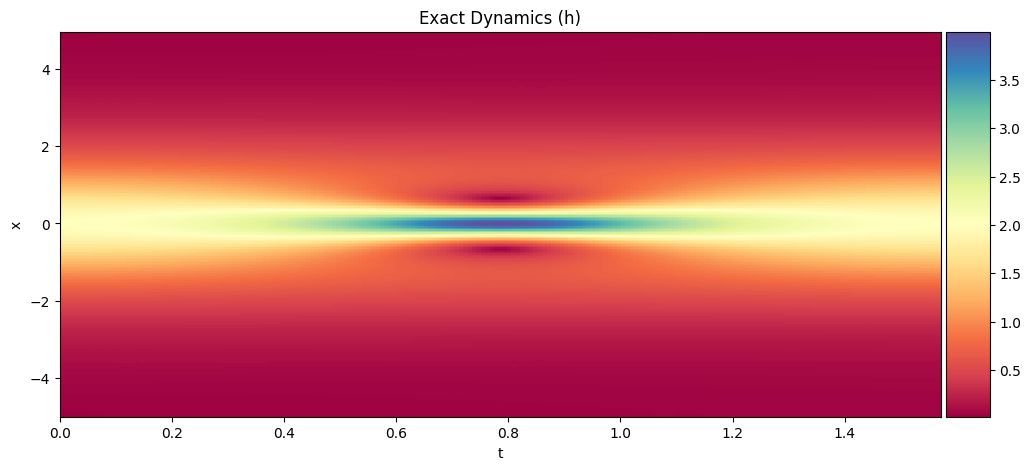

In [40]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact_h,
    interpolation="nearest",
    cmap="Spectral",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax, orientation="vertical")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("Exact Dynamics (h)")
plt.show()

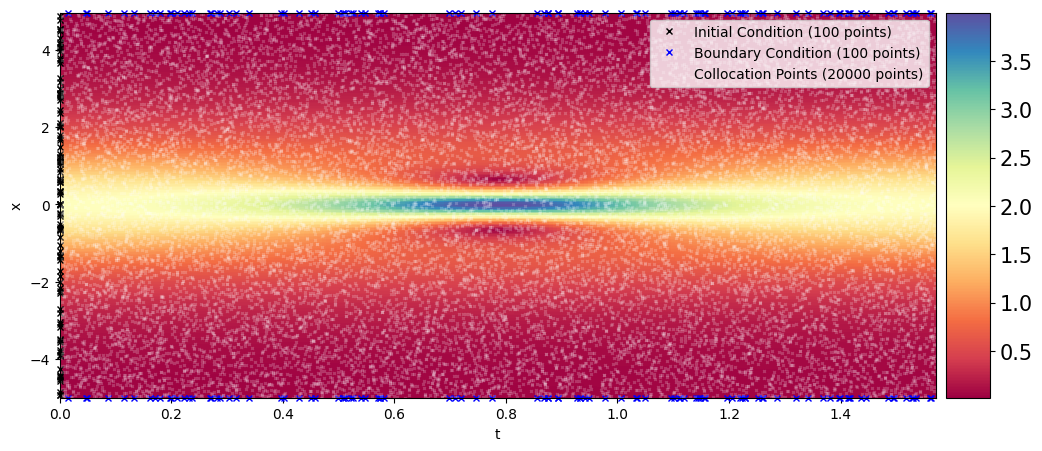

In [44]:
# Showing the sampled points
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact_h,
    interpolation="nearest",
    cmap="Spectral",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    xt_ic[:, 1].cpu().numpy(),
    xt_ic[:, 0].cpu().numpy(),
    "kx",
    label="Initial Condition (%d points)" % (N_ic),
    markersize=5,
    clip_on=False,
)
ax.plot(
    xt_lb[:, 1].cpu().numpy(),
    xt_lb[:, 0].cpu().numpy(),
    "bx",
    label="Boundary Condition (%d points)" % (N_bc),
    markersize=5,
    clip_on=False,
)
ax.plot(
    xt_ub[:, 1].cpu().numpy(),
    xt_ub[:, 0].cpu().numpy(),
    "bx",
    markersize=5,
    clip_on=False,
)
ax.plot(
    xt_f[:, 1].cpu().numpy(),
    xt_f[:, 0].cpu().numpy(),
    "wx",
    label="Collocation Points (%d points)" % (N_f),
    markersize=2,
    alpha=0.2,
)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.legend(loc="upper right")

# plt.savefig("Data_sampled.eps", format="eps")

plt.show()

In [45]:
class DNN(torch.nn.Module):
    # À compléter...
    def __init__(self, depth=8, input_size=2, hidden_size=20, output_size=1):
        """
        input of size N_u x 2  = N_u x (x,t) dimensions
        """
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        layers = [("input", nn.Linear(input_size, hidden_size))]

        layers.append(("activation input", nn.Tanh()))
        for i in range(depth):
            layers.append(
                ("hidden %d" % i, nn.Linear(hidden_size, hidden_size)))
            layers.append(("activation %d" % i, nn.Tanh()))
        layers.append(("output", nn.Linear(hidden_size, output_size)))

        dictLayers = OrderedDict(layers)
        self.seq = nn.Sequential(dictLayers)

    def forward(self, x, t):
        # print(x.shape, t.shape)
        X_u_train = torch.cat((x, t), dim=-1)
        return self.seq(X_u_train)

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u


dnn = DNN(input_size=2, hidden_size=50, output_size=2)

In [46]:
class PINN_Schrodinger(nn.Module):
    def __init__(self, dnn: DNN):
        super().__init__()
        self.dnn = dnn

    def forward(self, x, t):
        uv = self.dnn(x, t)
        u = uv[:, 0:1]
        v = uv[:, 1:2]

        return u, v

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            uv = self(x, t)
            u = uv[0].detach().cpu().numpy()
            v = uv[1].detach().cpu().numpy()
            return u, v


pinn = PINN_Schrodinger(dnn)

In [48]:
import torch.nn.functional as F


def pinns_loss(
    pinn: PINN_Schrodinger,
    xt_ic: torch.Tensor,
    xt_lb: torch.Tensor,
    xt_ub: torch.Tensor,
    xt_f: torch.Tensor,
    uv_ic: torch.Tensor,
):
    # Because we have some dependencies on some derivatives, we chose to compute everything in this function
    # instead of doing it in the forward function of the model
    # ic loss
    x_ic, t_ic = xt_ic[:, 0:1], xt_ic[:, 1:2]

    u_ic_pred, v_ic_pred = pinn(x_ic, t_ic)
    loss_ic = F.mse_loss(u_ic_pred, uv_ic[:, 0:1]) + F.mse_loss(
        v_ic_pred, uv_ic[:, 1:2]
    )

    # bc loss
    x_lb, t_lb = xt_lb[:, 0:1], xt_lb[:, 1:2]
    x_ub, t_ub = xt_ub[:, 0:1], xt_ub[:, 1:2]

    x_lb.requires_grad = True
    x_ub.requires_grad = True

    u_lb_pred, v_lb_pred = pinn(x_lb, t_lb)
    u_ub_pred, v_ub_pred = pinn(x_ub, t_ub)

    u_x_ub = torch.autograd.grad(
        u_ub_pred, x_ub, torch.ones_like(u_ub_pred), create_graph=True
    )[0][:, 0:1]
    v_x_ub = torch.autograd.grad(
        v_ub_pred, x_ub, torch.ones_like(v_ub_pred), create_graph=True
    )[0][:, 0:1]

    u_x_lb = torch.autograd.grad(
        u_lb_pred, x_lb, torch.ones_like(u_lb_pred), create_graph=True
    )[0][:, 0:1]
    v_x_lb = torch.autograd.grad(
        v_lb_pred, x_lb, torch.ones_like(v_lb_pred), create_graph=True
    )[0][:, 0:1]

    loss_bc = (
        F.mse_loss(u_lb_pred, u_ub_pred)
        + F.mse_loss(v_lb_pred, v_ub_pred)
        + F.mse_loss(u_x_lb, u_x_ub)
        + F.mse_loss(v_x_lb, v_x_ub)
    )

    # f loss
    x, t = xt_f[:, 0:1], xt_f[:, 1:2]

    x.requires_grad = True
    t.requires_grad = True

    u, v = pinn(x, t)

    u_t = torch.autograd.grad(
        u, t, torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    v_t = torch.autograd.grad(
        v, t, torch.ones_like(v), create_graph=True, retain_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x, torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    v_x = torch.autograd.grad(
        v, x, torch.ones_like(v), create_graph=True, retain_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x, torch.ones_like(u_x), create_graph=True, retain_graph=True
    )[0]
    v_xx = torch.autograd.grad(
        v_x, x, torch.ones_like(v_x), create_graph=True, retain_graph=True
    )[0]

    f_u = v_t - 0.5 * u_xx - (u**2 + v**2) * u
    f_v = u_t + 0.5 * v_xx + (u**2 + v**2) * v
    f_target = torch.zeros_like(f_u)

    loss_f = F.mse_loss(f_u, f_target) + F.mse_loss(f_v, f_target)

    loss = loss_ic + loss_bc + loss_f

    return loss, loss_ic, loss_bc, loss_f

In [57]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

dnn = DNN(input_size=2, hidden_size=50, output_size=2)
pinn = PINN_Schrodinger(dnn).to(device)
optimizer = torch.optim.LBFGS(
    pinn.parameters(),
    lr=0.8,
    max_iter=300,
    max_eval=500,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe",
)

# Training
pbar = tqdm(range(100))

for epoch in pbar:

    def loss_closure():
        optimizer.zero_grad()
        loss, loss_ic, loss_bc, loss_f = pinns_loss(
            pinn, xt_ic, xt_lb, xt_ub, xt_f, uv_ic
        )
        loss.backward()

        pbar.set_description(f"loss: {loss.item()}")

        writer.add_scalar("loss", loss, epoch)
        writer.add_scalar("loss_ic", loss_ic, epoch)
        writer.add_scalar("loss_bc", loss_bc, epoch)
        writer.add_scalar("loss_f", loss_f, epoch)

        return loss

    optimizer.step(loss_closure)

loss: 0.00019371043890714645: 100%|██████████| 100/100 [09:33<00:00,  5.74s/it]


In [46]:
# Save the model
torch.save(pinn.state_dict(), "pinn_schrodinger.pt")

In [49]:
# Load the model
pinn = PINN_Schrodinger(dnn).to(device)
pinn.load_state_dict(torch.load("pinn_schrodinger.pt"))

<All keys matched successfully>

In [50]:
Exact_x = data["x"].flatten()[:, None]
Exact_t = data["tt"].flatten()[:, None]
x_mesh, t_mesh = np.meshgrid(Exact_x, Exact_t)
Exact_xt = np.hstack([x_mesh.flatten()[:, None], t_mesh.flatten()[:, None]])
Exact_xt = torch.tensor(Exact_xt, dtype=torch.float).to(device)

Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]

In [51]:
with torch.no_grad():
    u_pred, v_pred = pinn.predict(Exact_xt[:, 0:1], Exact_xt[:, 1:2])
    h_pred = np.sqrt(u_pred**2 + v_pred**2)

In [52]:
x = data["x"].flatten()
t = data["tt"].flatten()
X, T = np.meshgrid(x, t)
X = X.flatten()[:, None]
T = T.flatten()[:, None]
u_sol = data["uu"].T
h_sol = np.abs(u_sol)

In [53]:
with torch.no_grad():
    u_pred, v_pred = pinn.predict(
        torch.tensor(X, dtype=torch.float).to(device),
        torch.tensor(T, dtype=torch.float).to(device),
    )
    h_pred = np.sqrt(u_pred**2 + v_pred**2)

h_pred = h_pred.reshape(u_sol.shape).T

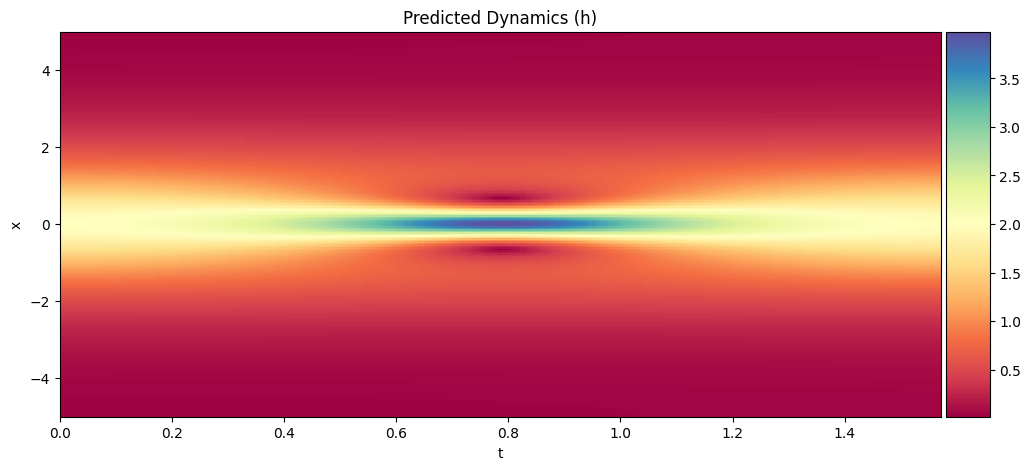

In [68]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111)
im = ax.imshow(
    h_pred,
    interpolation="nearest",
    cmap="Spectral",
    extent=[0, np.pi / 2, -5, 5],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("Predicted Dynamics (h)")

plt.show()

L2 error: 3.751511e-03
Mean Absolute Error: 2.715197e-03


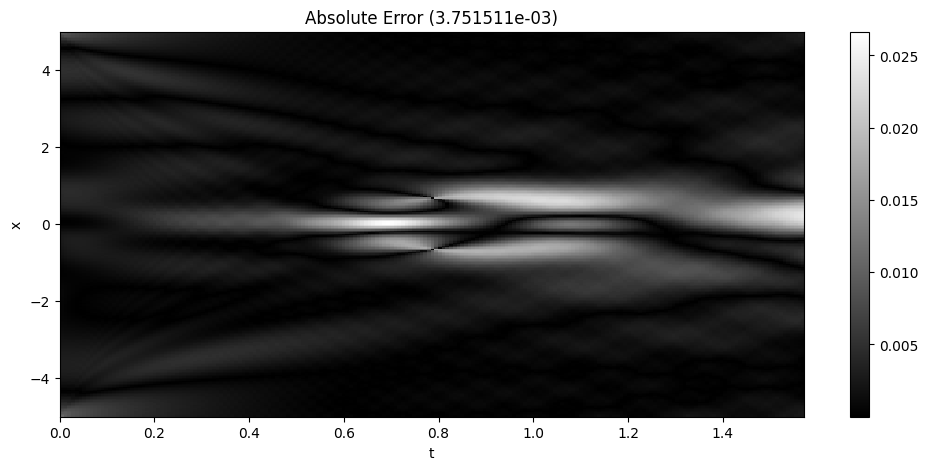

In [82]:
diff = np.linalg.norm(h_pred - h_sol.T, 2) / np.linalg.norm(h_sol.T, 2)
L2 = np.sqrt(np.mean(diff**2))
print("L2 error: %e" % (L2))

Error = np.abs(h_pred - h_sol.T)
print("Mean Absolute Error: %e" % (np.mean(Error)))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error,
    interpolation="nearest",
    cmap="gray",
    extent=[0, np.pi / 2, -5, 5],
    origin="lower",
    aspect="auto",
)
cbar = fig.colorbar(h)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("Absolute Error (%e)" % (L2))
plt.savefig("Schrodinger_error.eps", format="eps")
plt.show()

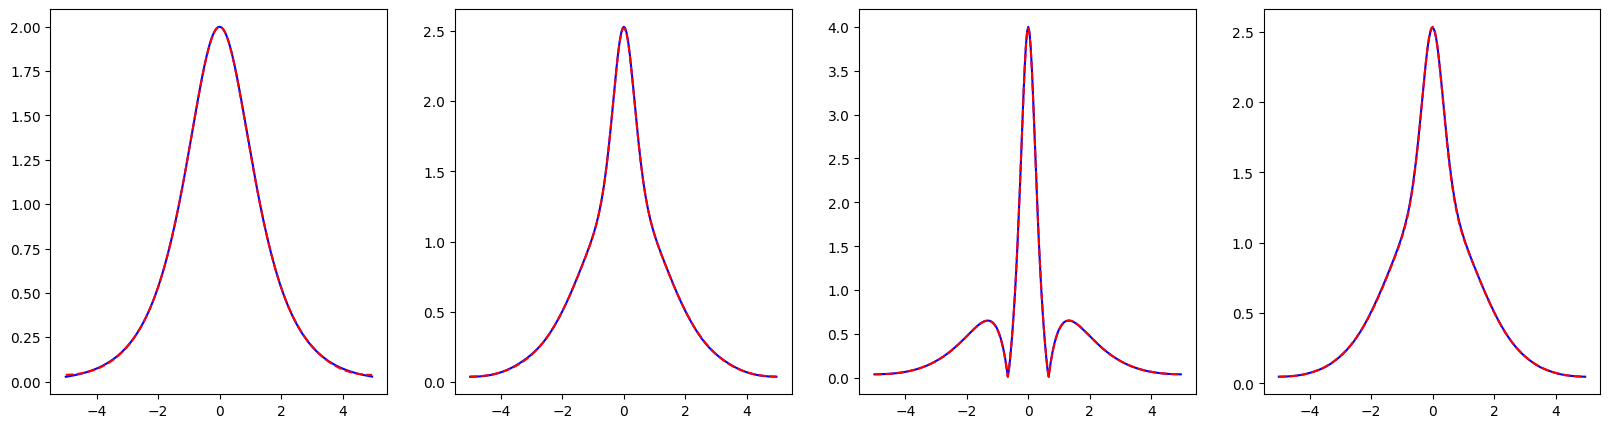

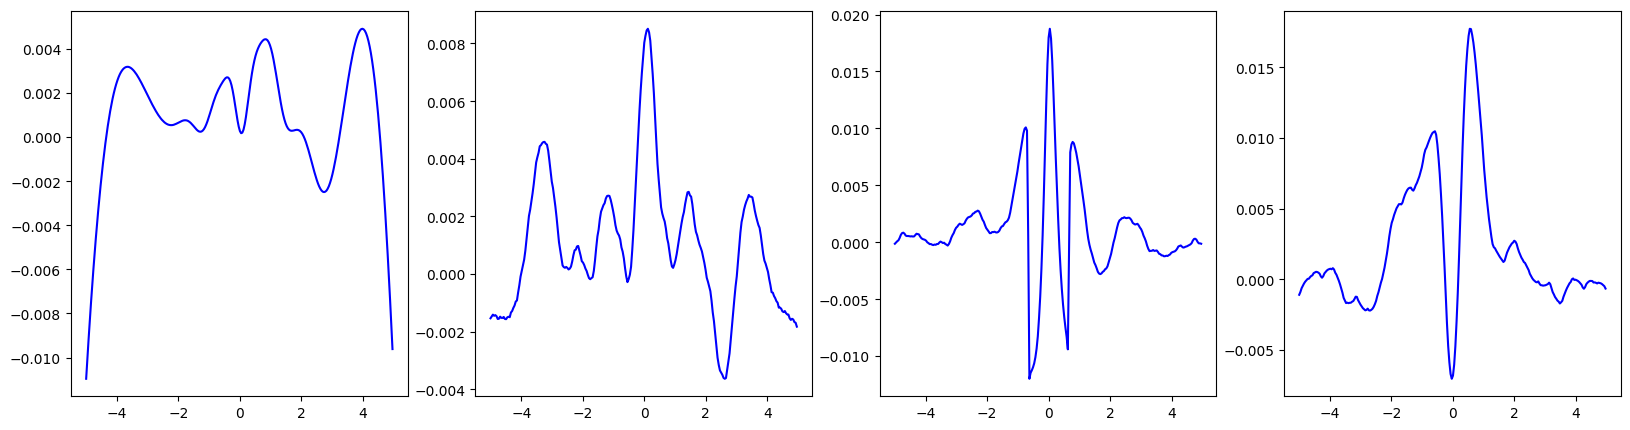

In [84]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, h_sol[0], "b-", label="Exact")
ax.plot(x, h_pred[:, 0], "r--", label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, h_sol[50, :], "b-", label="Exact")
ax.plot(x, h_pred[:, 50], "r--", label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, h_sol[100, :], "b-", label="Exact")
ax.plot(x, h_pred[:, 100], "r--", label="Prediction")

ax = fig.add_subplot(144)
ax.plot(x, h_sol[150, :], "b-", label="Exact")
ax.plot(x, h_pred[:, 150], "r--", label="Prediction")

plt.savefig("Schrodinger_profile_overview.eps", format="eps")

plt.show()

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, h_sol[0, :] - h_pred[:, 0], "b-", label="Error")

ax = fig.add_subplot(142)
ax.plot(x, h_sol[50, :] - h_pred[:, 50], "b-", label="Error")

ax = fig.add_subplot(143)
ax.plot(x, h_sol[100, :] - h_pred[:, 100], "b-", label="Error")

ax = fig.add_subplot(144)
ax.plot(x, h_sol[150, :] - h_pred[:, 150], "b-", label="Error")

plt.savefig("Schrodinger_error_profile_zoom.eps", format="eps")

plt.show()